In [ ]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import csv
import re
import pickle
import time
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from torch.nn.utils import clip_grad_norm_

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [ ]:
data_path = "/content/drive/MyDrive/train.csv"
df = pd.read_csv(data_path)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df['good'] = 1
df.loc[df[LABEL_COLUMNS].sum(axis=1) != 0, 'good'] = 0

In [ ]:
train_df, test_df = train_test_split(df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.1)

In [ ]:
train_df['comment_text'][80]

'"\n\nMinimization of textile effluent\n\nA proposed deletion template has been added to the article Minimization of textile effluent, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but this article may not satisfy Wikipedia\'s criteria for inclusion, and the deletion notice should explain why (see also ""What Wikipedia is not"" and Wikipedia\'s deletion policy).  You may prevent the proposed deletion by removing the  notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues raised. Even though removing the deletion notice will prevent deletion through the proposed deletion process, the article may still be deleted if it matches any of the speedy deletion criteria or it can be sent to Articles for Deletion, where it may be deleted if consensus to delete is reached. If you agree with the deletion of the art

<Axes: >

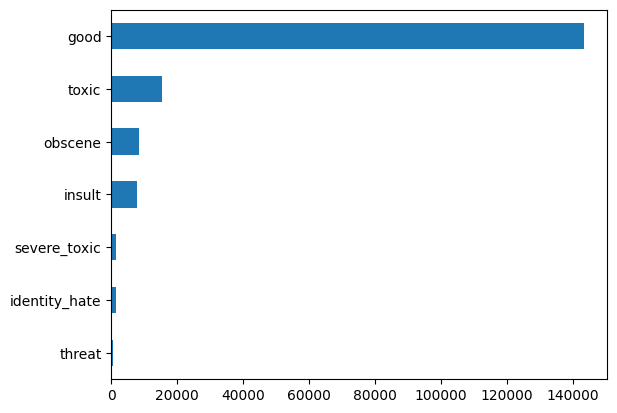

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh")

<Axes: >

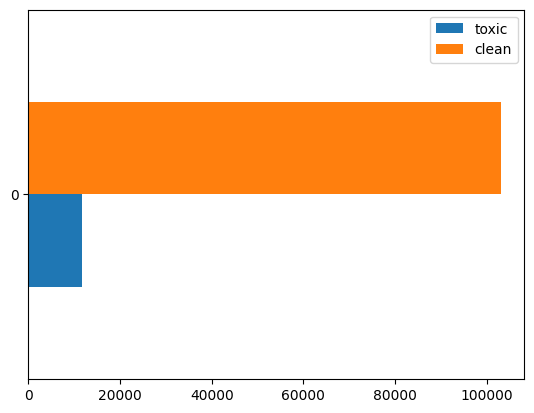

In [ ]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [ ]:
train_df = pd.concat([train_toxic, train_clean.sample(15_000)])

<Axes: >

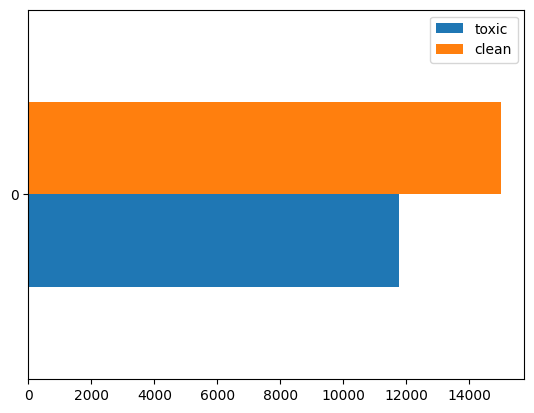

In [ ]:
train_toxic = train_df[train_df['good'] == 0]
train_clean = train_df[train_df['good'] == 1]

pd.DataFrame(dict(toxic=[len(train_toxic)], clean=[len(train_clean)])).plot(kind='barh')

In [ ]:
print(train_df.shape, val_df.shape, test_df.shape)

(26780, 9) (12766, 9) (31915, 9)


In [ ]:
def data_preprocessing(sentences):

    tokenized_sentences = []
    for sentence in tqdm(sentences, desc = 'Tokenize'):
        sentence = sentence.lower()
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)

        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
        sentence = sentence.strip()
        sentence = sentence.replace("\n"," ")
        sentence = re.sub(r'[^A-Za-z ]', '', sentence)
        sentence = re.sub('\s+', ' ', sentence)

        tokenized_sentences.append(nltk.word_tokenize(sentence))

    stop_words = set(stopwords.words('english'))

    removed_stop_words = []
    for sentence in tqdm(tokenized_sentences, desc = 'Stop_word_removal'):
        curr_sentence = []
        for token in sentence:
            if not token in stop_words:
                curr_sentence.append(token)
        
        removed_stop_words.append(curr_sentence)

    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for sentence in tqdm(removed_stop_words, desc = 'Lemmatization'):
        curr_sentence = []
        for token in sentence:
            curr_sentence.append(lemmatizer.lemmatize(token))

        lemmatized_sentence.append(curr_sentence)

    return lemmatized_sentence

In [ ]:
def vocab_builder(sentences):
    # Word dictionary
    word_vocab = {}
    unique_id = 1
    for sentence in sentences:
        for word in sentence:
            if word not in word_vocab:
                word_vocab[word] = unique_id
                unique_id += 1

    word_vocab['<PAD>'] = 0
    word_vocab['<OOV>'] = unique_id

    return word_vocab

In [ ]:
def text_to_sequence(sentences, word_vocab):

    text_sequece = []
    for sentence in sentences:
        curr_sequence = []
        for word in sentence:
            if word in word_vocab:
                curr_sequence.append(word_vocab[word])
            else:
                curr_sequence.append(word_vocab['<OOV>'])
        text_sequece.append(curr_sequence)

    return text_sequece

def pad_sequences(seq, maxlen):
    padded_seq = []
    if len(seq) < maxlen:
        padding_seq = [0] * (maxlen - len(seq))
        padded_seq = padding_seq + seq
    else:
        padded_seq = seq
        
    return padded_seq


def padding(sequence, max_length):
    new_sequence = []
    for i in range(len(sequence)):
        if len(sequence[i]) <= max_length:
            new_sequence.append(sequence[i])
        else:
            new_sequence.append(sequence[i][:max_length])
            

    sequence = new_sequence

    X = []
    for seq in tqdm(sequence, desc = 'Padding'):
        X.append(pad_sequences(seq, maxlen = max_length))

    return X

In [ ]:
max_length = 200

In [ ]:
# Train data
train_sentences = train_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
train_labels = train_df[cols].values

train_sentences = data_preprocessing(train_sentences)
word_vocab = vocab_builder(train_sentences)
vocab_size = len(word_vocab)
train_sequence = text_to_sequence(train_sentences, word_vocab)
train_sequence = padding(train_sequence, max_length)

X_train = np.array(train_sequence)
y_train = np.array(train_labels)

Padding: 100%|██████████| 26780/26780 [00:00<00:00, 207658.01it/s]


In [ ]:
# Val data
val_sentences = val_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
val_labels = val_df[cols].values

val_sentences = data_preprocessing(val_sentences)
val_sequence = text_to_sequence(val_sentences, word_vocab)
val_sequence = padding(val_sequence, max_length)

X_val = np.array(val_sequence)
y_val = np.array(val_labels)

Padding: 100%|██████████| 12766/12766 [00:00<00:00, 201671.10it/s]


In [ ]:
# Test data
test_sentences = test_df['comment_text'].values
cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']
test_labels = test_df[cols].values

test_sentences = data_preprocessing(test_sentences)
test_sequence = text_to_sequence(test_sentences, word_vocab)
test_sequence = padding(test_sequence, max_length)

X_test = np.array(test_sequence)
y_test = np.array(test_labels)

Padding: 100%|██████████| 31915/31915 [00:00<00:00, 215789.28it/s]


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(26780, 200) (26780, 7)
(12766, 200) (12766, 7)
(31915, 200) (31915, 7)


In [ ]:
print(vocab_size, max_length)

57902 200


In [ ]:
# save word2idx, maxlength
with open('/content/drive/MyDrive/MAGNET_TC/word2idx.pkl', 'wb') as f:
    pickle.dump(word_vocab, f)

with open('/content/drive/MyDrive/MAGNET_TC/maxlength.pkl', 'wb') as f:
    pickle.dump(max_length, f)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx])
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [ ]:
batch_size = 64

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
def load_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_file = '/content/drive/MyDrive/glove.6B.300d.txt'
embeddings_index = load_embeddings(embeddings_file)

In [ ]:
embeddings_dim = 300
pretrained_embeddings = []

for word in word_vocab:
    if word in embeddings_index:
        pretrained_embeddings.append(embeddings_index.get(word))
    else:
        pretrained_embeddings.append([0] * embeddings_dim)

pretrained_embeddings = torch.Tensor(pretrained_embeddings)

<ipython-input-33-c2cf0cd7e6ae>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  pretrained_embeddings = torch.Tensor(pretrained_embeddings)


In [ ]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, slope):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(out_features * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(slope)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, h, adj):
        Wh = self.W(h)
        num_nodes = Wh.size(0)
        Whi = Wh.repeat_interleave(num_nodes, dim=0)
        Whj = Wh.repeat(num_nodes, 1)
        WhiWhj = torch.cat([Whi, Whj], dim=1)
        Whcat = WhiWhj.view(num_nodes, num_nodes, Wh.size(1) * 2)
        e = self.leakyrelu(self.a(Whcat).squeeze(2))
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = self.softmax(attention)
        h_hat = torch.mm(attention, Wh)
        return h_hat


class MAGNET(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        adjacency_matrix,
        node_embeddings,
        num_heads=4,
        slope=0.01,
        dropout=0.5,
    ):

        super(MAGNET, self).__init__()

        self.node_embedding = nn.Embedding.from_pretrained(node_embeddings)

        self.rnn = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True
        )

        self.attentions1 = nn.ModuleList(
            [
                GraphAttentionLayer(input_size, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh1 = nn.Tanh()

        self.attentions2 = nn.ModuleList(
            [
                GraphAttentionLayer(hidden_size * 2, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh2 = nn.Tanh()

        self.adjacency_matrix = nn.Parameter(adjacency_matrix)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tokens, label_embedding):

        node_features = self.node_embedding(tokens).float()

        lstm_output, (hidden, _) = self.rnn(node_features)

        hidden_state = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)

        hidden_state = self.dropout(hidden_state)

        heads_out1 = [
            att(label_embedding, self.adjacency_matrix) for att in self.attentions1
        ]

        head_out1_mean = self.tanh1(torch.stack(heads_out1, dim=0).mean(0))

        heads_out2 = [
            att(head_out1_mean, self.adjacency_matrix) for att in self.attentions2
        ]

        head_out2_mean = self.tanh2(torch.stack(heads_out2, dim=0).mean(0))

        attention = self.dropout(head_out2_mean)

        attention = attention.transpose(0, 1)

        output = torch.mm(hidden_state, attention)

        return output

In [ ]:
def train_model(model, label_embedding, loss_function, optimizer, epochs, device, model_path):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in, label_embedding)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()

            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
        
        model.eval()    

        y_true_train, y_pred_train = [], []
        with torch.no_grad() :
            for batch in tqdm(dataloader_train, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                
                y_true_train.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_train.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model, "/content/drive/MyDrive/MAGNET_TC/" + model_path)
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [ ]:
def buildAdjacencyCOOC(data_label):
  adj = data_label.T.dot(data_label).astype('float')
  for i in range(len(adj)):
    adj[i] = adj[i] / adj[i,i]
  
  return torch.from_numpy(adj.astype('float32'))

In [ ]:
adjacency = buildAdjacencyCOOC(y_train)

In [ ]:
label_embedding = torch.zeros(7, 300)

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'good']

for index, label in enumerate(labels):
  words = label.split('_')
  num_of_words = len(words)
  
  for sublabel in words:
    if sublabel in embeddings_index.keys():
      label_embedding[index] +=  torch.from_numpy(embeddings_index[sublabel])
  label_embedding[index] = label_embedding[index]/num_of_words

label_embedding = label_embedding.float().to(device)
print(label_embedding, label_embedding.shape)

tensor([[-0.1338,  0.4449, -0.1320,  ..., -0.3913, -0.4084,  0.0045],
        [-0.1352,  0.1137, -0.3520,  ..., -0.1768,  0.1053, -0.3155],
        [-0.3243,  0.0416,  0.2132,  ...,  0.1782,  0.2137, -1.1418],
        ...,
        [-0.0302,  0.2444,  0.0910,  ...,  0.2767, -0.0892, -0.3096],
        [-0.1872, -0.1358, -0.0330,  ...,  0.4099, -0.0587,  0.1831],
        [-0.1360, -0.1159, -0.0171,  ..., -0.3376,  0.0701,  0.2464]],
       device='cuda:0') torch.Size([7, 300])


In [ ]:
with open('/content/drive/MyDrive/MAGNET_TC/label_embedding.pkl', 'wb') as f:
    pickle.dump(label_embedding, f)

In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model_4 = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 4)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_4.parameters(), lr = learning_rate)
train_loss_4, val_loss_4, avg_epoch_time = train_model(magnet_model_4, label_embedding, loss_function, optimizer, epochs, device, "tc_head4.pth")

Epoch :  1


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.91it/s]


Train F1 Score (Micro) 0.4397961041325323
Val F1 Score (Micro) 0.7729346173340091
Train loss 0.4085800723841765
Val loss 0.19955353684723376
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.18it/s]


Train F1 Score (Micro) 0.6129631858359743
Val F1 Score (Micro) 0.8747315155265936
Train loss 0.3681270850017702
Val loss 0.11585581075400114
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.12it/s]


Train F1 Score (Micro) 0.5786878916575094
Val F1 Score (Micro) 0.8024116196218143
Train loss 0.3463747218286792
Val loss 0.1884810044616461
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 53.66it/s]


Train F1 Score (Micro) 0.5859503893021506
Val F1 Score (Micro) 0.8215185457927988
Train loss 0.3532313510668875
Val loss 0.16663181498646737
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 57.00it/s]


Train F1 Score (Micro) 0.6297562528547898
Val F1 Score (Micro) 0.8623695976154994
Train loss 0.33050982316240207
Val loss 0.11854853732511401
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 57.70it/s]


Train F1 Score (Micro) 0.5775969077510488
Val F1 Score (Micro) 0.8647881924477668
Train loss 0.3167421101528022
Val loss 0.10541393561288714
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 49.52it/s]


Train F1 Score (Micro) 0.6376349260914403
Val F1 Score (Micro) 0.8753493160758935
Train loss 0.31080225188294003
Val loss 0.10571715259924531
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 57.94it/s]


Train F1 Score (Micro) 0.5715596330275229
Val F1 Score (Micro) 0.8471300043216909
Train loss 0.3008019111890497
Val loss 0.11249493174254895
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 60.60it/s]


Train F1 Score (Micro) 0.6326711008709008
Val F1 Score (Micro) 0.8686671423742818
Train loss 0.2964007498114092
Val loss 0.1085503998445347
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.09it/s]


Train F1 Score (Micro) 0.6567860573624262
Val F1 Score (Micro) 0.8317956538314907
Train loss 0.29651029454210776
Val loss 0.13200699243694544
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.48it/s]


Train F1 Score (Micro) 0.6568488388263106
Val F1 Score (Micro) 0.8584156933213537
Train loss 0.2933098809317928
Val loss 0.11455216316506267
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.53it/s]


Train F1 Score (Micro) 0.6581732598616064
Val F1 Score (Micro) 0.8610057460472453
Train loss 0.2790960609770618
Val loss 0.11302747782319784
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.47it/s]


Train F1 Score (Micro) 0.6561200195060383
Val F1 Score (Micro) 0.8525163448380721
Train loss 0.2756636255823058
Val loss 0.12237707836553455
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.63it/s]


Train F1 Score (Micro) 0.6308877577696105
Val F1 Score (Micro) 0.8461747890008168
Train loss 0.26921930389927795
Val loss 0.12398915989324451
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.65it/s]


Train F1 Score (Micro) 0.6574539244289476
Val F1 Score (Micro) 0.8244103041589075
Train loss 0.27109609430473575
Val loss 0.1397448117658496
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 56.11it/s]


Train F1 Score (Micro) 0.6571639650601886
Val F1 Score (Micro) 0.8444581233408995
Train loss 0.2671074415234791
Val loss 0.1253250976651907
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 56.30it/s]


Train F1 Score (Micro) 0.6868907148513052
Val F1 Score (Micro) 0.8544417877505978
Train loss 0.270772373548271
Val loss 0.12238593246787786
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 52.38it/s]


Train F1 Score (Micro) 0.6789892052373068
Val F1 Score (Micro) 0.8430841051125667
Train loss 0.26329006162207563
Val loss 0.1355305527150631
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.11it/s]


Train F1 Score (Micro) 0.6513773796192608
Val F1 Score (Micro) 0.8507819120252678
Train loss 0.25663819258281323
Val loss 0.12819783439859747
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 61.76it/s]


Train F1 Score (Micro) 0.6314365250929224
Val F1 Score (Micro) 0.8608441608364726
Train loss 0.2547096920184133
Val loss 0.12553493704646826
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 61.78it/s]


Train F1 Score (Micro) 0.6427591612776798
Val F1 Score (Micro) 0.8380336553443442
Train loss 0.25565766961022607
Val loss 0.13270732790231704
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 61.61it/s]


Train F1 Score (Micro) 0.6547934598087978
Val F1 Score (Micro) 0.8572628364191639
Train loss 0.25224138248649586
Val loss 0.13481296230107545
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 61.25it/s]


Train F1 Score (Micro) 0.6480051966101182
Val F1 Score (Micro) 0.8593016599885518
Train loss 0.24882082733590163
Val loss 0.14064162135124206
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 56.80it/s]


Train F1 Score (Micro) 0.6535334584115072
Val F1 Score (Micro) 0.8394745024875622
Train loss 0.25226700394847795
Val loss 0.14197970217093825
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 55.50it/s]


Train F1 Score (Micro) 0.653572276287681
Val F1 Score (Micro) 0.8414412322458299
Train loss 0.2510891186522413
Val loss 0.13687478616833687
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.61it/s]


Train F1 Score (Micro) 0.6883350219520432
Val F1 Score (Micro) 0.8302174742464707
Train loss 0.2527676570387046
Val loss 0.1487546830251813
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.24it/s]


Train F1 Score (Micro) 0.62046563725098
Val F1 Score (Micro) 0.8238304678128748
Train loss 0.24851589509439354
Val loss 0.15321692937985062
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.14it/s]


Train F1 Score (Micro) 0.704515865519618
Val F1 Score (Micro) 0.845289988917621
Train loss 0.24575295421986135
Val loss 0.14991453792899848
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 54.65it/s]


Train F1 Score (Micro) 0.6748647879305437
Val F1 Score (Micro) 0.8397564359488207
Train loss 0.24448913968832794
Val loss 0.1547797211073339
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.63it/s]


Train F1 Score (Micro) 0.6723921783362393
Val F1 Score (Micro) 0.843394777265745
Train loss 0.24457782734549985
Val loss 0.14890897750854493
------------------------------------------------


In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model_2 = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 2)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_2.parameters(), lr = learning_rate)
train_loss_2, val_loss_2, avg_epoch_time = train_model(magnet_model_2, label_embedding, loss_function, optimizer, epochs, device, "tc_head2.pth")

Epoch :  1


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.80it/s]


Train F1 Score (Micro) 0.5784569297020149
Val F1 Score (Micro) 0.851819724684141
Train loss 0.4059362349618306
Val loss 0.15932306956499814
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.59it/s]


Train F1 Score (Micro) 0.6124588565159088
Val F1 Score (Micro) 0.8685366925443093
Train loss 0.3700039846231374
Val loss 0.15083350002765655
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.73it/s]


Train F1 Score (Micro) 0.569349462449727
Val F1 Score (Micro) 0.8506930999767677
Train loss 0.3462592723261485
Val loss 0.126546711307019
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.64it/s]


Train F1 Score (Micro) 0.6065170971421886
Val F1 Score (Micro) 0.8333976684937853
Train loss 0.3319646992447268
Val loss 0.1527826176956296
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.31it/s]


Train F1 Score (Micro) 0.6436100752547756
Val F1 Score (Micro) 0.8667893961708395
Train loss 0.32679999898896867
Val loss 0.11484843203797937
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.29it/s]


Train F1 Score (Micro) 0.6617976083322619
Val F1 Score (Micro) 0.8612807665581684
Train loss 0.3132572413415499
Val loss 0.11379154831171036
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 59.65it/s]


Train F1 Score (Micro) 0.5852384675527756
Val F1 Score (Micro) 0.8660431380034357
Train loss 0.30517218317080796
Val loss 0.10648184627294541
Best model saved
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.89it/s]


Train F1 Score (Micro) 0.6559829650728686
Val F1 Score (Micro) 0.8543820731661466
Train loss 0.29605115615809446
Val loss 0.11836412455886602
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.60it/s]


Train F1 Score (Micro) 0.6332052018439152
Val F1 Score (Micro) 0.8170024841291748
Train loss 0.2895403814130865
Val loss 0.1442423353344202
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 59.12it/s]


Train F1 Score (Micro) 0.6539955837549264
Val F1 Score (Micro) 0.8472598614875037
Train loss 0.28409285107205196
Val loss 0.12700344609096648
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.60it/s]


Train F1 Score (Micro) 0.6801607771769728
Val F1 Score (Micro) 0.8496148263927653
Train loss 0.2783532737618699
Val loss 0.1249046972580254
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.58it/s]


Train F1 Score (Micro) 0.6373988612526221
Val F1 Score (Micro) 0.83359375
Train loss 0.2726125608694013
Val loss 0.1309250649344176
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.69it/s]


Train F1 Score (Micro) 0.6937569356990562
Val F1 Score (Micro) 0.8450704225352114
Train loss 0.27038243576564197
Val loss 0.13247965125367045
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.64it/s]


Train F1 Score (Micro) 0.6623617288174249
Val F1 Score (Micro) 0.8516393754036702
Train loss 0.27056213555444114
Val loss 0.1256922161206603
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.68it/s]


Train F1 Score (Micro) 0.670505278090708
Val F1 Score (Micro) 0.856435457853472
Train loss 0.2629315748917459
Val loss 0.12484964769333601
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.76it/s]


Train F1 Score (Micro) 0.6891346229975456
Val F1 Score (Micro) 0.8533293786148599
Train loss 0.259237435061778
Val loss 0.1302857779338956
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 68.01it/s]


Train F1 Score (Micro) 0.6249784344171019
Val F1 Score (Micro) 0.8534686446914823
Train loss 0.25706362774093283
Val loss 0.1259436267800629
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 67.37it/s]


Train F1 Score (Micro) 0.6602109328145342
Val F1 Score (Micro) 0.8525301755321174
Train loss 0.2563778540399592
Val loss 0.13511652213521302
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 200/200 [00:02<00:00, 66.83it/s]


Train F1 Score (Micro) 0.6821766993481952
Val F1 Score (Micro) 0.846081208687441
Train loss 0.2524062518145987
Val loss 0.13714428352192043
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 65.43it/s]


Train F1 Score (Micro) 0.6774755046463966
Val F1 Score (Micro) 0.8474088655032744
Train loss 0.25215865508041974
Val loss 0.1407348359003663
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 55.33it/s]


Train F1 Score (Micro) 0.6295065521349301
Val F1 Score (Micro) 0.847021309690465
Train loss 0.2513811946413113
Val loss 0.13628552919253706
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.01it/s]


Train F1 Score (Micro) 0.6507876799927776
Val F1 Score (Micro) 0.8400947241740752
Train loss 0.25148954272696966
Val loss 0.14135141497477888
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.14it/s]


Train F1 Score (Micro) 0.6374845488257107
Val F1 Score (Micro) 0.8527856067333308
Train loss 0.25379828393886084
Val loss 0.13708277057856322
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 63.78it/s]


Train F1 Score (Micro) 0.7926064445546948
Val F1 Score (Micro) 0.8698026194429072
Train loss 0.22163606251907803
Val loss 0.14008872820064425
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.81it/s]


Train F1 Score (Micro) 0.8356903163950143
Val F1 Score (Micro) 0.8433538122802657
Train loss 0.18091972158034833
Val loss 0.148624026440084
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.94it/s]


Train F1 Score (Micro) 0.8413345712237486
Val F1 Score (Micro) 0.8502480510276399
Train loss 0.16758678133348293
Val loss 0.14434066738933324
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 62.29it/s]


Train F1 Score (Micro) 0.8392942298521698
Val F1 Score (Micro) 0.8427107675714544
Train loss 0.1685355120385177
Val loss 0.15317918153479695
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 63.29it/s]


Train F1 Score (Micro) 0.8360956309859834
Val F1 Score (Micro) 0.8560597932982871
Train loss 0.1642489741803069
Val loss 0.14919201649725436
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.67it/s]


Train F1 Score (Micro) 0.8232606809249143
Val F1 Score (Micro) 0.8801419466975666
Train loss 0.17577870177696314
Val loss 0.12026082828640938
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 64.58it/s]


Train F1 Score (Micro) 0.8322100656455143
Val F1 Score (Micro) 0.8600960838550007
Train loss 0.16374362793557684
Val loss 0.13701716884970666
------------------------------------------------


In [ ]:
epochs = 30
learning_rate = 0.001

magnet_model_8 = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 8)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_8.parameters(), lr = learning_rate)
train_loss_8, val_loss_8, avg_epoch_time = train_model(magnet_model_8, label_embedding, loss_function, optimizer, epochs, device, "tc_head8.pth")

Epoch :  1


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.97it/s]


Train F1 Score (Micro) 0.5972623657086765
Val F1 Score (Micro) 0.8569739079015448
Train loss 0.40232650370188144
Val loss 0.1469253147765994
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 41.94it/s]


Train F1 Score (Micro) 0.5242667194562671
Val F1 Score (Micro) 0.8481323913976816
Train loss 0.3687356066376611
Val loss 0.14411442704498767
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.00it/s]


Train F1 Score (Micro) 0.5538982401226483
Val F1 Score (Micro) 0.8537830728763732
Train loss 0.3483935537301271
Val loss 0.12971081074327231
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 45.16it/s]


Train F1 Score (Micro) 0.657511433684629
Val F1 Score (Micro) 0.8562302638742696
Train loss 0.3315497530459789
Val loss 0.12828447435051202
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.09it/s]


Train F1 Score (Micro) 0.609437894316138
Val F1 Score (Micro) 0.8459237381195805
Train loss 0.3405272220228054
Val loss 0.1328416520357132
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 200/200 [00:05<00:00, 38.38it/s]


Train F1 Score (Micro) 0.6664254790588859
Val F1 Score (Micro) 0.8743433196081214
Train loss 0.3194125359411171
Val loss 0.10597954608500004
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.39it/s]


Train F1 Score (Micro) 0.6448266373142543
Val F1 Score (Micro) 0.8695395077241481
Train loss 0.3059885064784553
Val loss 0.11104178298264741
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 48.72it/s]


Train F1 Score (Micro) 0.65340682602301
Val F1 Score (Micro) 0.8534463361584039
Train loss 0.2999804981212912
Val loss 0.12383493147790432
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.40it/s]


Train F1 Score (Micro) 0.6467129727075002
Val F1 Score (Micro) 0.8680491152576325
Train loss 0.29140832725032134
Val loss 0.10606171185150742
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 44.66it/s]


Train F1 Score (Micro) 0.6474530268477973
Val F1 Score (Micro) 0.8701327597715641
Train loss 0.28588716013619325
Val loss 0.10783888714388012
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.05it/s]


Train F1 Score (Micro) 0.5987084429562306
Val F1 Score (Micro) 0.8573417378862292
Train loss 0.281364091291917
Val loss 0.11002618094906211
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.49it/s]


Train F1 Score (Micro) 0.6098522784176263
Val F1 Score (Micro) 0.8583615124500461
Train loss 0.2770884123793081
Val loss 0.1167777231708169
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 44.20it/s]


Train F1 Score (Micro) 0.6880606248066811
Val F1 Score (Micro) 0.8454204844752754
Train loss 0.2715028302481749
Val loss 0.13236382130533456
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.43it/s]


Train F1 Score (Micro) 0.6717620099619908
Val F1 Score (Micro) 0.8410832132291587
Train loss 0.2687331485364204
Val loss 0.13180718183517456
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 48.47it/s]


Train F1 Score (Micro) 0.6176792813096692
Val F1 Score (Micro) 0.8194671233422279
Train loss 0.26559445578471574
Val loss 0.1422380517050624
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.99it/s]


Train F1 Score (Micro) 0.7624777719840093
Val F1 Score (Micro) 0.8879472346070232
Train loss 0.2512639078149363
Val loss 0.11264071833342314
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 46.53it/s]


Train F1 Score (Micro) 0.7589129892794815
Val F1 Score (Micro) 0.8649572649572649
Train loss 0.23327607805518374
Val loss 0.1282836414501071
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.81it/s]


Train F1 Score (Micro) 0.7556946275239304
Val F1 Score (Micro) 0.8456684296917746
Train loss 0.21935611319570383
Val loss 0.1420108176022768
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 45.96it/s]


Train F1 Score (Micro) 0.724500265345834
Val F1 Score (Micro) 0.8530977219501811
Train loss 0.21559930719026232
Val loss 0.1352478289976716
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.33it/s]


Train F1 Score (Micro) 0.7235198108959928
Val F1 Score (Micro) 0.869588093806374
Train loss 0.250153014405246
Val loss 0.1261766416952014
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 42.61it/s]


Train F1 Score (Micro) 0.7429106369700043
Val F1 Score (Micro) 0.8571955583428633
Train loss 0.23196947994266318
Val loss 0.1316206161491573
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.37it/s]


Train F1 Score (Micro) 0.7216283414572477
Val F1 Score (Micro) 0.8727123328602376
Train loss 0.2309629432412491
Val loss 0.12487753499299288
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 45.69it/s]


Train F1 Score (Micro) 0.7530910726660425
Val F1 Score (Micro) 0.8505722228239285
Train loss 0.2248340516500086
Val loss 0.14190904093906284
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.01it/s]


Train F1 Score (Micro) 0.7378304046822289
Val F1 Score (Micro) 0.8602367349986932
Train loss 0.22134148594445432
Val loss 0.14360739627853036
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 46.75it/s]


Train F1 Score (Micro) 0.7378082978810719
Val F1 Score (Micro) 0.8437106798337591
Train loss 0.22075290778798534
Val loss 0.1487482204847038
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.00it/s]


Train F1 Score (Micro) 0.7293670351334225
Val F1 Score (Micro) 0.871062106210621
Train loss 0.2210028466361804
Val loss 0.13388398697599768
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 48.78it/s]


Train F1 Score (Micro) 0.7277045750155517
Val F1 Score (Micro) 0.8569904761904763
Train loss 0.22241391988386686
Val loss 0.13582354951649905
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 50.99it/s]


Train F1 Score (Micro) 0.7401253539840825
Val F1 Score (Micro) 0.8423639732294779
Train loss 0.22580262867462664
Val loss 0.15124761156737804
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 200/200 [00:04<00:00, 49.23it/s]


Train F1 Score (Micro) 0.7431808701034812
Val F1 Score (Micro) 0.8631014449575451
Train loss 0.22104508459994787
Val loss 0.13909965327940882
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 200/200 [00:03<00:00, 51.73it/s]


Train F1 Score (Micro) 0.7621360983214299
Val F1 Score (Micro) 0.8397129186602871
Train loss 0.21572193531830727
Val loss 0.15893487993627786
------------------------------------------------


# Evaluation

In [ ]:
def test_scores(model, device, label_embedding):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            pred_batch = model(sequence_in, label_embedding)

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    y_pred = y_pred >= 0.5

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'good']))

In [ ]:
best_model_4 = torch.load('/content/drive/MyDrive/MAGNET_TC/tc_head4.pth')
test_scores(best_model_4, device, label_embedding)

Evaluate: 100%|██████████| 499/499 [00:08<00:00, 59.74it/s]


Test Accuracy 0.8532351558828137
Test F1 Score (Micro) 0.8639126086622048
Classification report
               precision    recall  f1-score   support

        toxic       0.98      0.08      0.15      3002
 severe_toxic       0.34      0.29      0.31       297
      obscene       0.93      0.15      0.25      1612
       threat       0.06      0.15      0.08        91
       insult       0.86      0.15      0.25      1495
identity_hate       0.20      0.18      0.19       277
         good       0.97      0.95      0.96     28733

    micro avg       0.95      0.79      0.86     35507
    macro avg       0.62      0.28      0.31     35507
 weighted avg       0.95      0.79      0.82     35507
  samples avg       0.86      0.86      0.86     35507



In [ ]:
best_model_2 = torch.load('/content/drive/MyDrive/MAGNET_TC/tc_head2.pth')
test_scores(best_model_2, device, label_embedding)

Evaluate: 100%|██████████| 499/499 [00:07<00:00, 66.74it/s]


Test Accuracy 0.8549271502428325
Test F1 Score (Micro) 0.8648640353569456
Classification report
               precision    recall  f1-score   support

        toxic       0.99      0.09      0.16      3002
 severe_toxic       0.34      0.31      0.32       297
      obscene       0.91      0.15      0.26      1612
       threat       0.05      0.15      0.08        91
       insult       0.86      0.15      0.26      1495
identity_hate       0.23      0.22      0.23       277
         good       0.97      0.95      0.96     28733

    micro avg       0.95      0.79      0.86     35507
    macro avg       0.62      0.29      0.32     35507
 weighted avg       0.95      0.79      0.82     35507
  samples avg       0.86      0.86      0.86     35507



In [ ]:
best_model_8 = torch.load('/content/drive/MyDrive/MAGNET_TC/tc_head8.pth')
test_scores(best_model_8, device, label_embedding)

Evaluate: 100%|██████████| 499/499 [00:10<00:00, 49.14it/s]


Test Accuracy 0.8607864640451198
Test F1 Score (Micro) 0.871574589943152
Classification report
               precision    recall  f1-score   support

        toxic       0.96      0.36      0.52      3002
 severe_toxic       0.22      0.83      0.35       297
      obscene       0.81      0.57      0.67      1612
       threat       0.04      0.53      0.08        91
       insult       0.72      0.55      0.62      1495
identity_hate       0.15      0.60      0.23       277
         good       0.97      0.96      0.96     28733

    micro avg       0.88      0.87      0.87     35507
    macro avg       0.55      0.63      0.49     35507
 weighted avg       0.94      0.87      0.89     35507
  samples avg       0.88      0.89      0.88     35507



In [ ]:
num_params = sum(p.numel() for p in best_model_4.parameters() if p.requires_grad) 

print(best_model_4)
print(f'The model has {num_params:,} trainable parameters')

MAGNET(
  (node_embedding): Embedding(57902, 300)
  (rnn): LSTM(300, 250, batch_first=True, bidirectional=True)
  (attentions1): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=300, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh1): Tanh()
  (attentions2): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=500, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh2): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
)
The model has 2,712,049 trainable parameters


In [ ]:
print('Train loss', train_loss_2)
print('Val loss', val_loss_2)

Train loss [0.4059362349618306, 0.3700039846231374, 0.3462592723261485, 0.3319646992447268, 0.32679999898896867, 0.3132572413415499, 0.30517218317080796, 0.29605115615809446, 0.2895403814130865, 0.28409285107205196, 0.2783532737618699, 0.2726125608694013, 0.27038243576564197, 0.27056213555444114, 0.2629315748917459, 0.259237435061778, 0.25706362774093283, 0.2563778540399592, 0.2524062518145987, 0.25215865508041974, 0.2513811946413113, 0.25148954272696966, 0.25379828393886084, 0.22163606251907803, 0.18091972158034833, 0.16758678133348293, 0.1685355120385177, 0.1642489741803069, 0.17577870177696314, 0.16374362793557684]
Val loss [0.15932306956499814, 0.15083350002765655, 0.126546711307019, 0.1527826176956296, 0.11484843203797937, 0.11379154831171036, 0.10648184627294541, 0.11836412455886602, 0.1442423353344202, 0.12700344609096648, 0.1249046972580254, 0.1309250649344176, 0.13247965125367045, 0.1256922161206603, 0.12484964769333601, 0.1302857779338956, 0.1259436267800629, 0.13511652213521

In [ ]:
print('Train loss', train_loss_4)
print('Val loss', val_loss_4)

Train loss [0.4085800723841765, 0.3681270850017702, 0.3463747218286792, 0.3532313510668875, 0.33050982316240207, 0.3167421101528022, 0.31080225188294003, 0.3008019111890497, 0.2964007498114092, 0.29651029454210776, 0.2933098809317928, 0.2790960609770618, 0.2756636255823058, 0.26921930389927795, 0.27109609430473575, 0.2671074415234791, 0.270772373548271, 0.26329006162207563, 0.25663819258281323, 0.2547096920184133, 0.25565766961022607, 0.25224138248649586, 0.24882082733590163, 0.25226700394847795, 0.2510891186522413, 0.2527676570387046, 0.24851589509439354, 0.24575295421986135, 0.24448913968832794, 0.24457782734549985]
Val loss [0.19955353684723376, 0.11585581075400114, 0.1884810044616461, 0.16663181498646737, 0.11854853732511401, 0.10541393561288714, 0.10571715259924531, 0.11249493174254895, 0.1085503998445347, 0.13200699243694544, 0.11455216316506267, 0.11302747782319784, 0.12237707836553455, 0.12398915989324451, 0.1397448117658496, 0.1253250976651907, 0.12238593246787786, 0.135530552

In [ ]:
print('Train loss', train_loss_8)
print('Val loss', val_loss_8)

Train loss [0.40232650370188144, 0.3687356066376611, 0.3483935537301271, 0.3315497530459789, 0.3405272220228054, 0.3194125359411171, 0.3059885064784553, 0.2999804981212912, 0.29140832725032134, 0.28588716013619325, 0.281364091291917, 0.2770884123793081, 0.2715028302481749, 0.2687331485364204, 0.26559445578471574, 0.2512639078149363, 0.23327607805518374, 0.21935611319570383, 0.21559930719026232, 0.250153014405246, 0.23196947994266318, 0.2309629432412491, 0.2248340516500086, 0.22134148594445432, 0.22075290778798534, 0.2210028466361804, 0.22241391988386686, 0.22580262867462664, 0.22104508459994787, 0.21572193531830727]
Val loss [0.1469253147765994, 0.14411442704498767, 0.12971081074327231, 0.12828447435051202, 0.1328416520357132, 0.10597954608500004, 0.11104178298264741, 0.12383493147790432, 0.10606171185150742, 0.10783888714388012, 0.11002618094906211, 0.1167777231708169, 0.13236382130533456, 0.13180718183517456, 0.1422380517050624, 0.11264071833342314, 0.1282836414501071, 0.142010817602

In [ ]:
# print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

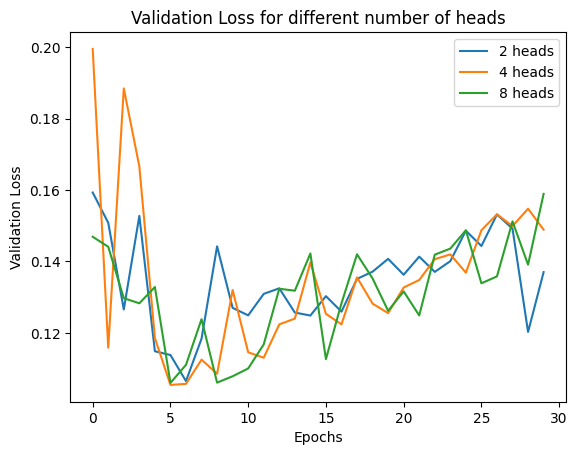

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_loss_2, label='2 heads')
plt.plot(val_loss_4, label='4 heads')
plt.plot(val_loss_8, label='8 heads')

plt.title('Validation Loss for different number of heads')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

plt.legend()

plt.show()

In [ ]:
def inference(model, device, label_embedding, sequence_in):

    labels_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate', 'good']

    model.eval()
    
    with torch.no_grad():
            sequence_in = torch.tensor(sequence_in).to(device)

            pred_batch = model(sequence_in, label_embedding)

            out = torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist()
            
            out = np.array(out) >= 0.5

            pos = []
            neg = []

            for i, value in enumerate(out[0]) :
                if(value == True) :
                    pos.append(labels_names[i])
                else :
                    neg.append(labels_names[i])

            print("Positive Labels : ", pos)
            print("Negative Labels : ", neg)
            

In [ ]:
with open("/content/drive/MyDrive/MAGNET_TC/maxlength.pkl", "rb") as f:
    maxlen = pickle.load(f)

with open("/content/drive/MyDrive/MAGNET_TC/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)

with open("/content/drive/MyDrive/MAGNET_TC/label_embedding.pkl", "rb") as f:
    label_embed = pickle.load(f)

best_model = torch.load('/content/drive/MyDrive/MAGNET_TC/tc_head4.pth')

dev = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
while True : 
    sample_sentence = input("Enter the sentence : ")

    sample_sentence = data_preprocessing([sample_sentence])
    vocab_size = len(word2idx)
    sample_sequence = text_to_sequence(sample_sentence, word2idx)
    sample_sequence = padding(sample_sequence, maxlen)
    inference(best_model, dev, label_embed, sample_sequence)